# Лабораторная работа №4. Корреляционный анализ

> Вариант № ??

**Распределения**:

$X \sim ??$

$Y \sim ??$

Объём выборок $n$ &mdash; ?


In [42]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Немного магии для того, чтобы рисунки стали больше
import pylab
pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

# Вспомогательные классы и функции, определённые тут же (см. репозиторий)
# https://github.com/BobNobrain/matstat-labs/tree/master/s
from s import Sample, HTable
from s.utils import table, printf, load_styles
load_styles()

## 1. Исходные данные

In [43]:
X =  stats.chi2(15)
Y = stats.uniform(5, 20)
n = 100

print('Характеристики наблюдаемых случайных величин:')
table(
    ['СВ', 'Распределение', 'Параметры', '$m_i$', '$\\sigma_i^2$', '$n_i$'],
    [
        ['X', '$X^2$', '$k=15$', X.mean(), X.var(), n],
        ['Y', '$R$', '$a=5, b=25$', Y.mean(), Y.var(), n]
    ]
)

Характеристики наблюдаемых случайных величин:


СВ,Распределение,Параметры,$m_i$,$\sigma_i^2$,$n_i$
X,$X^2$,$k=15$,15.0,30.0,100
Y,$R$,"$a=5, b=25$",15.0,33.33333333333333,100


In [44]:
x = Sample.from_distribution("x", X, count=n)
y = Sample.from_distribution("y", Y, count=n)

print('Выборочные характеристики:')
table(
    ['СВ', 'Среднее $\\overline{x_i}$', '$s^2_i$', '$s_i$'],
    [
        [
            s._name,
            round(s.mean(), 4),
            round(s.s() ** 2, 4),
            round(s.s(), 4)
        ] for s in [x, y]
    ]
)

Выборочные характеристики:


СВ,Среднее $\overline{x_i}$,$s^2_i$,$s_i$
x,15.8962,30.138,5.4898
y,15.0966,29.6943,5.4492


In [45]:
def pierson(x, y):
    return stats.pearsonr(x.data(), y.data())[0]

def spirmen(x, y):
    return stats.spearmanr(x.data(), y.data())[0]

def kendell(x, y):
    return stats.kendalltau(x.data(), y.data())[0]

In [46]:
t = HTable(rows=2, cols=6, head_rows=1)
t.fill(row=0, head=True, content=[
    'СВ',
    'Среднее $\\overline{x_i}$',
    'Оценка дисперсии $s^2_i$',
    'КК по Пирсону $r_{xy}$',
    'КК по Спирмену $\\rho_{xy}$',
    'КК по Кендаллу $\\tau_{xy}$'
])
t.fill(col=0, content=['X', 'Y'])
t.map_col(0, lambda c: c.add_class('head'))
t.fill(col=1, content=[
    round(sample.mean(), 4)        for sample in [x, y]
])
t.fill(col=2, content=[
    round(sample.s() ** 2, 4)      for sample in [x, y]
])

t.map_row(0, lambda c: c.span(rowspan=2).add_class('text-center'), limits=(3, 6))

t.fill(row=0, content=[
    None,
    None,
    None,
    pierson(x, y),
    spirmen(x, y),
    kendell(x, y)
])

print('Выборочные характеристики:')
t.show()


Выборочные характеристики:


In [47]:
print('Проверка значимости коэффициентов корреляции:')

alpha = 0.05

r_p_value = stats.pearsonr(x.data(), y.data())[1]
rho_p_value = stats.spearmanr(x.data(), y.data())[1]
tau_p_value = stats.kendalltau(x.data(), y.data())[1]

def solution(p_value, alpha):
    return 'H0' if p_value > alpha else 'H1'

r_solution = solution(r_p_value, alpha)
rho_solution = solution(rho_p_value, alpha)
tau_solution = solution(tau_p_value, alpha)

def is_error(res):
    if res == 'H0':
        return 'Ошибки нет'
    else:
        return 'Ошибка 1-го порядка'

table(
    [
        'Статистическая гипотеза $H_0$',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        ['$H_0: r_{XY} = 0$', r_p_value, r_solution, is_error(r_solution)],
        ['$H_0: \\rho_{XY} = 0$', rho_p_value, rho_solution, is_error(rho_solution)],
        ['$H_0: \\tau_{XY} = 0$', tau_p_value, tau_solution, is_error(tau_solution)]
    ]
)

Проверка значимости коэффициентов корреляции:


Статистическая гипотеза $H_0$,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
$H_0: r_{XY} = 0$,0.9333057332705172,H0,Ошибки нет
$H_0: \rho_{XY} = 0$,0.9793899599832927,H0,Ошибки нет
$H_0: \tau_{XY} = 0$,0.9762415779624265,H0,Ошибки нет


## 2. Визуальное представление двумерной выборки

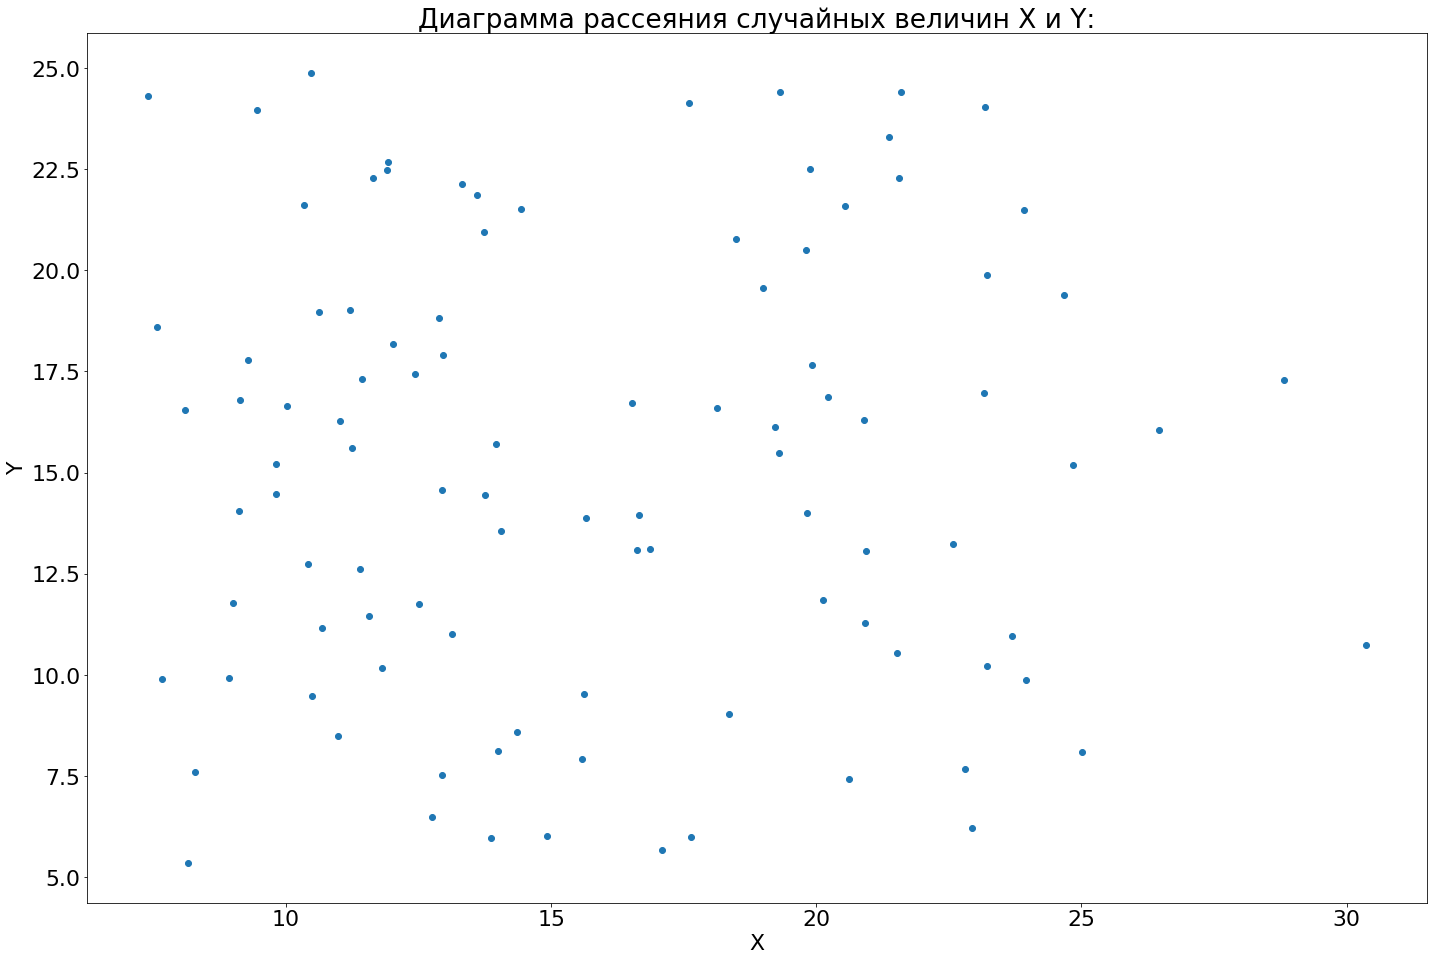

In [48]:
fig, ax = plt.subplots()

ax.set_title('Диаграмма рассеяния случайных величин X и Y:')
ax.set_xlabel('X')
ax.set_ylabel('Y');

# параметр s=? используется для задания размера маркеров
ax.scatter(x.data(), y.data());


## 3. Проверка независимости методом таблиц сопряженности

Статистическая гипотеза:

$$ H_0: F_Y(y | X \in \Delta_1) = ... = F_Y(y | X \in \Delta_k) = F_Y(y) $$

In [53]:
print('Эмпирическая/теоретическая таблицы сопряженности:')

def choose_cell_x(x):
    index = (x - 5) // 3
    if index > 4:
        index = 4
    return int(index)

def choose_cell_y(y):
    index = (y - 5) // 4
    return int(index)
    

table_values = np.zeros((5,5))
for t in range(x.n()):
    i=choose_cell_x(x.data()[t])
    j=choose_cell_y(y.data()[t])
    table_values[i][j] = table_values[i][j] + 1
    
table_row_names = []
offset = 5
for i in range(4):
    table_row_names.append('$\\Delta_{} = [{};{})$'.format(i, str(round(offset, 1)),' '+str(round(offset + 3,1))) )
    offset += 3
table_row_names.append('$\\Delta_{} = [{};{})$'.format(4, str(round(offset, 1)),' '+'{\infty}'))

table(
    [
        'X \\ Y',
        *['[{};{})'.format(str(5 + 4 * i), str(5 + 4 * (i + 1))) for i in range(5)]
    ],
    [
        [table_row_names[i]] + table_values[i].tolist() for i in range(5)
    ]
)
    
def mij (i, j):
    s_1 = s_2 = 0
    for t in range(5):
        s_1 += table_values[t, j]
        s_2 += table_values[i, t]
    return (s_1 * s_2) / 100

th_values = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        th_values[i][j] = mij(i,j)

print('Теоретическая таблица сопряженности:')

table(
    [
        'X \\ Y',
        *['[{};{})'.format(str(5 + 4 * i), str(5 + 4 * (i + 1))) for i in range(5)]
    ],
    [
        [table_row_names[i]] + th_values[i].tolist() for i in range(5)
    ]
)

print (table_values.sum(), th_values.sum())

Эмпирическая/теоретическая таблицы сопряженности:


X \ Y,[5;9),[9;13),[13;17),[17;21),[21;25)
$\Delta_0 = [5; 8)$,0.0,1.0,0.0,1.0,1.0
$\Delta_1 = [8; 11)$,3.0,5.0,6.0,2.0,3.0
$\Delta_2 = [11; 14)$,4.0,5.0,5.0,7.0,5.0
$\Delta_3 = [14; 17)$,3.0,1.0,6.0,0.0,1.0
$\Delta_4 = [17; {\infty})$,6.0,8.0,11.0,7.0,9.0


Теоретическая таблица сопряженности:


X \ Y,[5;9),[9;13),[13;17),[17;21),[21;25)
$\Delta_0 = [5; 8)$,0.48,0.6,0.84,0.51,0.57
$\Delta_1 = [8; 11)$,3.04,3.8,5.32,3.23,3.61
$\Delta_2 = [11; 14)$,4.16,5.2,7.28,4.42,4.94
$\Delta_3 = [14; 17)$,1.76,2.2,3.08,1.87,2.09
$\Delta_4 = [17; {\infty})$,6.56,8.2,11.48,6.97,7.79


100.0 100.00000000000001


In [27]:
alpha = 0.05

z = 0
for i in range(5):
    for j in range(5):
        z += (((table_values[i, j] - th_values[i, j])**2)/th_values[i, j])

print(z)
p = 1 - stats.chi2(5-1, 5-1).cdf(z) #right p-value

d = solution(alpha, p)

table(
    [
        'Выборочное значение статистики критерия',
        'p-value',
        'Статистическое решение при $\\alpha={}$'.format(alpha),
        'Ошибка статистического решения'
    ],
    [
        [z, p, d, is_error(d)]
    ]
)

13.860725211753893


Выборочное значение статистики критерия,p-value,Статистическое решение при $\alpha=0.05$,Ошибка статистического решения
13.860725211753893,0.04284024788874463,H0,Ошибки нет


## 4. Исследование корреляционной связи

Случайная величина $ U = \lambda X + (1 - \lambda) Y, \lambda \in [0; 1]$

Случайная величина $ V = \lambda X^3 + (1 - \lambda) Y^3, \lambda \in [0; 1]$

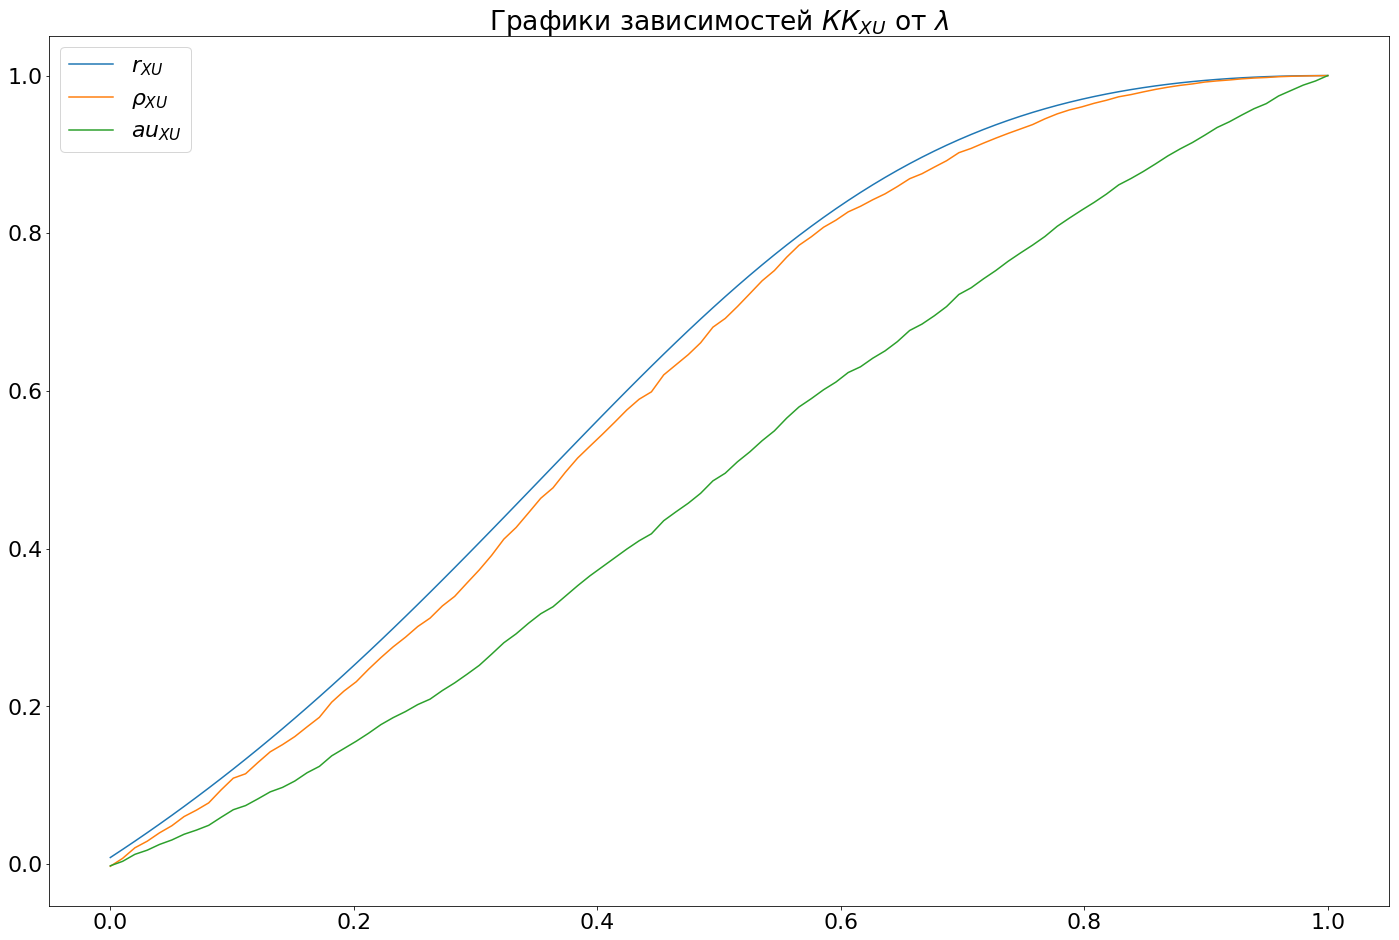

In [50]:
lambda_values = np.linspace(0, 1, 100)

def u(l, x, y):
    U = l * x.data() + (1 - l) * y.data()
    return Sample.from_data("u", U)

fig, ax = plt.subplots()
ax.set_title('Графики зависимостей $КК_{XU}$ от $\\lambda$')

pierson_values = [
    pierson(x, u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, pierson_values, label='$r_{XU}$')

spirmen_values = [
    spirmen(x, u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, spirmen_values, label='$\\rho_{XU}$')

kendell_values = [
    kendell(x, u(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, kendell_values, label='$\tau_{XU}$')

ax.legend()

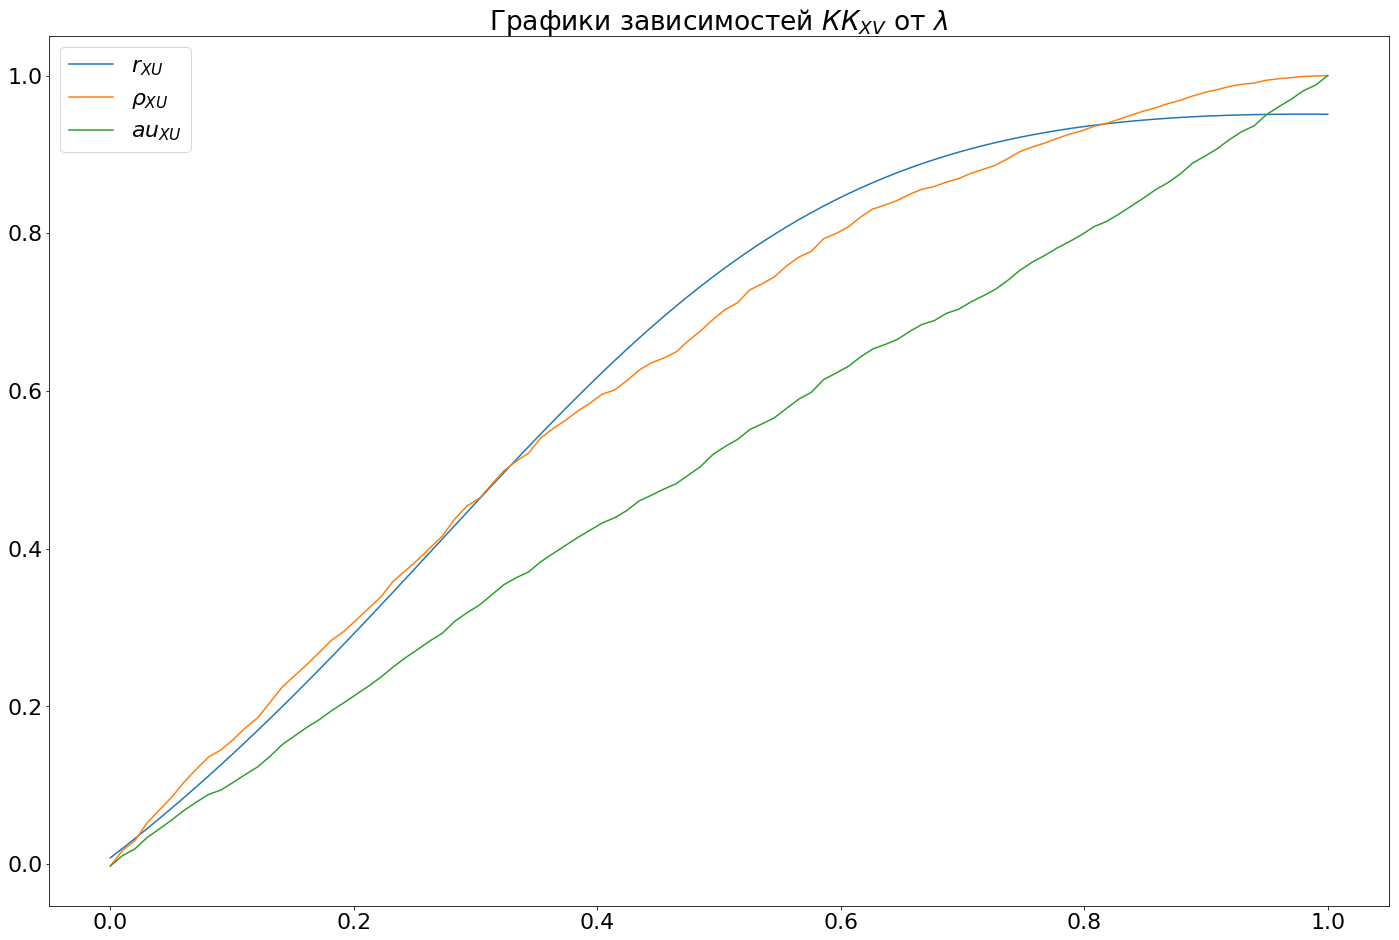

In [51]:
def v(l, x, y):
    V = l * x.data()**3 + (1 - l) * y.data()**3
    return Sample.from_data("v", V)

fig, ax = plt.subplots()
ax.set_title('Графики зависимостей $КК_{XV}$ от $\\lambda$');

pierson_values = [
    pierson(x, v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, pierson_values, label='$r_{XU}$')

spirmen_values = [
    spirmen(x, v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, spirmen_values, label='$\\rho_{XU}$')

kendell_values = [
    kendell(x, v(l, x, y)) for l in lambda_values
]
ax.plot(lambda_values, kendell_values, label='$\tau_{XU}$')

ax.legend();

### Выводы:

1. ...
2. ...

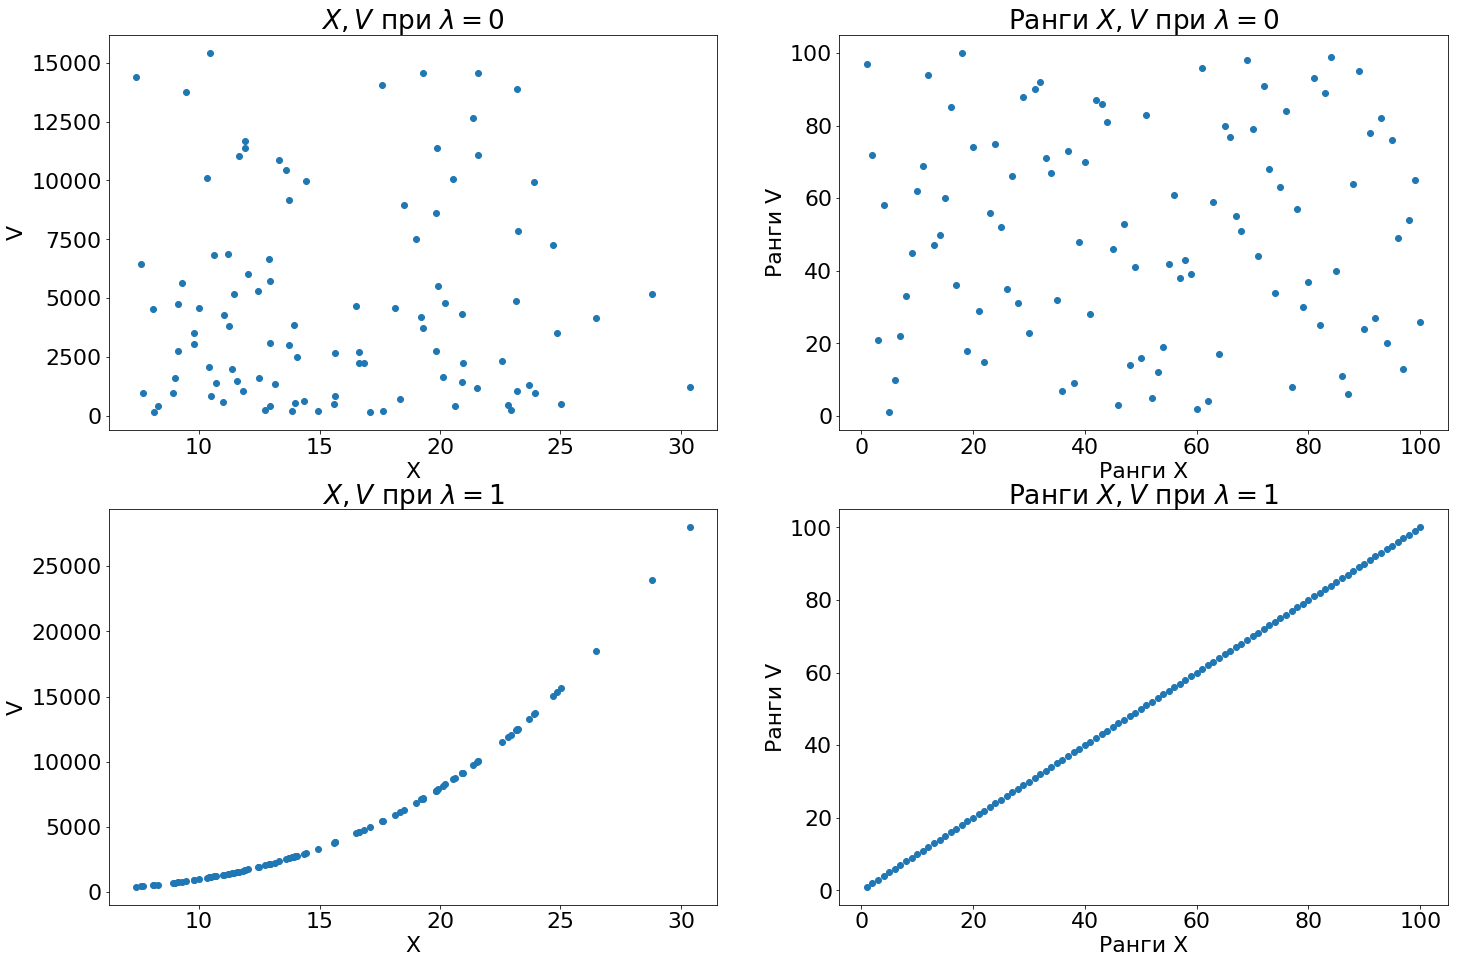

In [52]:
fig, ax = plt.subplots(2, 2)

v0 = Sample.from_data('v0', v(0, x, y).data())

ax[0][0].set_title('$X, V$ при $\\lambda = 0$')
ax[0][0].set_xlabel('X')
ax[0][0].set_ylabel('V')
ax[0][0].scatter(x.data(), v0.data())

ax[0][1].set_title('Ранги $X, V$ при $\\lambda = 0$')
ax[0][1].set_xlabel('Ранги X')
ax[0][1].set_ylabel('Ранги V')
ax[0][1].scatter(x.ranks(), v0.ranks())

v1 = Sample.from_data('v1', v(1, x, y).data())

ax[1][0].set_title('$X, V$ при $\\lambda = 1$')
ax[1][0].set_xlabel('X')
ax[1][0].set_ylabel('V')
ax[1][0].scatter(x.data(), v1.data())

ax[1][1].set_title('Ранги $X, V$ при $\\lambda = 1$')
ax[1][1].set_xlabel('Ранги X')
ax[1][1].set_ylabel('Ранги V')
ax[1][1].scatter(x.ranks(), v1.ranks());

# TODO

In [2]:
from scipy import stats

In [8]:
stats.t.cdf(df=6, x=-6.2)

0.00040576053236895666

### Выводы:

1. ...
2. ...